# Chapter 3 : Coding Attention Mechanisms

## 3.1 The problem with modeling long sequences

There was no code in this section.

RNNs cannot directly access the earlier hidden states(neural network) from the endcoder. So, it relies on the current hidden state and therfore can lead to loss of cotext.

## 3.2 Capturing data dependencies with attention mechanisms

Again No code in this section.

One major shortcoming in RNN is that it must remember the entire encoded input in a single hidden state before passing it to the decoder.

Using an attention mechanism, the text-generating decoder part of the network can access all input tokens selectively. This means that some input tokens are more important than others for generating a given output token. The importance is determined by the so-called attention weights, which we will compute later.


Later we found out that, RNNs are not required for building deep NNs for NLP. Instead, we could use trasformer with a self attention mechanism.

Self-attention is a mechanism in transformers that is used to compute more efficient input representations by allowing each position in a sequence to interact with and weigh the importance of all other positions within the same sequence.

## 3.3 Attending to different parts of the input with self-attention

In self-attention, the "self" refers to the mechanism's ability to compute attention weights by relating different positions within a single input
 sequence. It assesses and learns the relationships and dependencies between
 various parts of the input itself, such as words in a sentence or pixels in an
 image. This is in contrast to traditional attention mechanisms, where the
 focus is on the relationships between elements of two different sequences,
 such as in sequence-to-sequence models where the attention might be
 between an input sequence and an output sequence.

### 3.3.1 A simple self-attention mechanism without trainable weights

The goal of self-attention is to compute a context vector, for each input element, that
 combines information from all other input elements. In the example depicted below, we
 compute the context vector z(2) . The importance or contribution of each input element for
 computing z(2) is determined by the attention weights α21 to α2T. When computing z(2) , the
 attention weights are calculated with respect to input element x(2) and all other inputs.

For eg., x(1), corresponds to a d
dimensional embedding vector representing a specific token

A context vector can be interpreted as an enriched
 embedding vector.

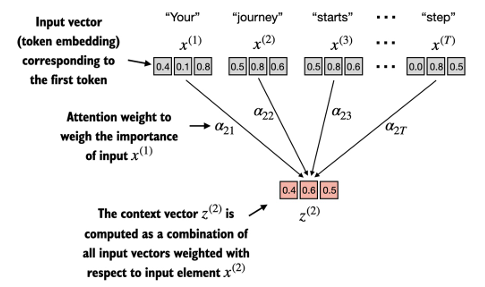

The following input sentence has already been embedded
 into 3-dimensional vectors.

In [2]:
import torch

inputs = torch.tensor(
  [[0.43, 0.15, 0.89], # Your     (x^1)
   [0.55, 0.87, 0.66], # journey  (x^2)
   [0.57, 0.85, 0.64], # starts   (x^3)
   [0.22, 0.58, 0.33], # with     (x^4)
   [0.77, 0.25, 0.10], # one      (x^5)
   [0.05, 0.80, 0.55]] # step     (x^6)
)

By convention, the unnormalized attention weights are referred to as "attention scores" whereas the normalized attention scores, which sum to 1, are referred to as "attention weights"

We use input sequence element x(2), 
, as an example to compute context vector z(2)

The first step is to compute the unnormalized attention scores(omega) by computing the dot product between the query x(2) 
 and all other input tokens:

In [3]:
query = inputs[1]  # 2nd input token is the query

attn_scores_2 = torch.empty(inputs.shape[0])
for i, x_i in enumerate(inputs):
    attn_scores_2[i] = torch.dot(x_i, query) # dot product (transpose not necessary here since they are 1-dim vectors)

print(attn_scores_2)

tensor([0.9544, 1.4950, 1.4754, 0.8434, 0.7070, 1.0865])


Here, the dot product is essentially just a concise way of multiplying two vectors
 element-wise and then summing the products.

In the context of self-attention mechanisms, the dot product
 determines the extent to which elements in a sequence attend to each other:
 the higher the dot product, the higher the similarity and attention score
 between two elements.


In the next step, we normalize each of the attention
 scores that we computed previously to obtain attention weights(alpha), so that it sum upto 1.

In [4]:
attn_weights_2_tmp = attn_scores_2 / attn_scores_2.sum()

print("Attention weights:", attn_weights_2_tmp)
print("Sum:", attn_weights_2_tmp.sum())

Attention weights: tensor([0.1455, 0.2278, 0.2249, 0.1285, 0.1077, 0.1656])
Sum: tensor(1.0000)


However, in practice, using the softmax function for normalization, which is better at handling extreme values and has more desirable gradient properties during training, is common and recommended.

In [5]:
def softmax_naive(x):
    return torch.exp(x) / torch.exp(x).sum(dim=0)

attn_weights_2_naive = softmax_naive(attn_scores_2)

print("Attention weights:", attn_weights_2_naive)
print("Sum:", attn_weights_2_naive.sum())

Attention weights: tensor([0.1385, 0.2379, 0.2333, 0.1240, 0.1082, 0.1581])
Sum: tensor(1.)


In addition, the softmax function ensures that the attention weights are
 always positive. This makes the output interpretable as probabilities or
 relative importance, where higher weights indicate greater importance.

We use python implementation of softmax because the above can give overflow or underflow.

In [6]:
attn_weights_2 = torch.softmax(attn_scores_2, dim=0)

print("Attention weights:", attn_weights_2)
print("Sum:", attn_weights_2.sum())

Attention weights: tensor([0.1385, 0.2379, 0.2333, 0.1240, 0.1082, 0.1581])
Sum: tensor(1.)


The final step, after calculating and normalizing the attention scores to obtain the
 attention weights for query x(2) , is to compute the context vector z (2) . This context vector is a
 combination of all input vectors x(1) to x(T) weighted by the attention weights.


Step 3: compute the context vector z(2)
 by multiplying the embedded input tokens, x(i)
 with the attention weights and sum the resulting vectors:

In [7]:
query = inputs[1] # 2nd input token is the query

context_vec_2 = torch.zeros(query.shape)
for i,x_i in enumerate(inputs):
    context_vec_2 += attn_weights_2[i]*x_i

print(context_vec_2)

tensor([0.4419, 0.6515, 0.5683])


### 3.3.2 Computing attention weights for all input tokens

Next, we are generalizing this computation to compute all attention weights and context vectors

First, in step 1, we add an additional for-loop to
 compute the dot products for all pairs of inputs.

In [8]:
attn_scores = torch.empty(6, 6)

for i, x_i in enumerate(inputs):
    for j, x_j in enumerate(inputs):
        attn_scores[i, j] = torch.dot(x_i, x_j)

print(attn_scores)

tensor([[0.9995, 0.9544, 0.9422, 0.4753, 0.4576, 0.6310],
        [0.9544, 1.4950, 1.4754, 0.8434, 0.7070, 1.0865],
        [0.9422, 1.4754, 1.4570, 0.8296, 0.7154, 1.0605],
        [0.4753, 0.8434, 0.8296, 0.4937, 0.3474, 0.6565],
        [0.4576, 0.7070, 0.7154, 0.3474, 0.6654, 0.2935],
        [0.6310, 1.0865, 1.0605, 0.6565, 0.2935, 0.9450]])


The above values are attention scores which are unnormalized.

We can achieve the same as above more efficiently via matrix multiplication:

In [9]:
attn_scores = inputs @ inputs.T
print(attn_scores)

tensor([[0.9995, 0.9544, 0.9422, 0.4753, 0.4576, 0.6310],
        [0.9544, 1.4950, 1.4754, 0.8434, 0.7070, 1.0865],
        [0.9422, 1.4754, 1.4570, 0.8296, 0.7154, 1.0605],
        [0.4753, 0.8434, 0.8296, 0.4937, 0.3474, 0.6565],
        [0.4576, 0.7070, 0.7154, 0.3474, 0.6654, 0.2935],
        [0.6310, 1.0865, 1.0605, 0.6565, 0.2935, 0.9450]])


In step 2, we now normalize each row so that the
 values in each row sum to 1:

In [10]:
attn_weights = torch.softmax(attn_scores, dim=-1)
print(attn_weights)

tensor([[0.2098, 0.2006, 0.1981, 0.1242, 0.1220, 0.1452],
        [0.1385, 0.2379, 0.2333, 0.1240, 0.1082, 0.1581],
        [0.1390, 0.2369, 0.2326, 0.1242, 0.1108, 0.1565],
        [0.1435, 0.2074, 0.2046, 0.1462, 0.1263, 0.1720],
        [0.1526, 0.1958, 0.1975, 0.1367, 0.1879, 0.1295],
        [0.1385, 0.2184, 0.2128, 0.1420, 0.0988, 0.1896]])


let's briefly
 verify that the rows indeed all sum to 1:

In [11]:
row_2_sum = sum([0.1385, 0.2379, 0.2333, 0.1240, 0.1082, 0.1581])
print("Row 2 sum:", row_2_sum)

print("All row sums:", attn_weights.sum(dim=-1))

Row 2 sum: 1.0
All row sums: tensor([1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000])


 In the third and last step, we now use these attention weights to compute all
 context vectors via matrix multiplication:

In [12]:
all_context_vecs = attn_weights @ inputs
print(all_context_vecs)

tensor([[0.4421, 0.5931, 0.5790],
        [0.4419, 0.6515, 0.5683],
        [0.4431, 0.6496, 0.5671],
        [0.4304, 0.6298, 0.5510],
        [0.4671, 0.5910, 0.5266],
        [0.4177, 0.6503, 0.5645]])


## 3.4 Implementing self-attention with trainable weights

The self-attention mechanism used in GPT is called scaled dot
product attention. 

The most notable difference from the previous self-attention mechanism is the introduction of weight matrices that are
 updated during model training

### 3.4.1 Computing the attention weights step by step

 In the first step of the self-attention mechanism with trainable weight matrices, we
 compute query (q), key (k), and value (v) vectors for input elements x. The query vector q(2) is obtained
 via matrix multiplication between the input x(2) and the weight matrix Wq. Similarly, we obtain
 the key and value vectors via matrix multiplication involving the weight matrices Wk and Wv.

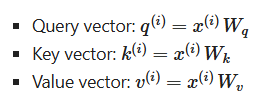

The embedding dimensions of the input x
 and the query vector q
 can be the same or different, depending on the model's design and specific implementation

In [13]:
x_2 = inputs[1] # second input element
d_in = inputs.shape[1] # the input embedding size, d=3
d_out = 2 # the output embedding size, d=2

Below, we initialize the three weight matrices; note that we are setting requires_grad=False to reduce clutter in the outputs for illustration purposes, but if we were to use the weight matrices for model training, we would set requires_grad=True to update these matrices during model training

In [14]:
torch.manual_seed(123)

W_query = torch.nn.Parameter(torch.rand(d_in, d_out), requires_grad=False)
W_key   = torch.nn.Parameter(torch.rand(d_in, d_out), requires_grad=False)
W_value = torch.nn.Parameter(torch.rand(d_in, d_out), requires_grad=False)

Next we compute the query, key, and value vectors:

In [15]:
query_2 = x_2 @ W_query # _2 because it's with respect to the 2nd input element
key_2 = x_2 @ W_key 
value_2 = x_2 @ W_value

print(query_2)

tensor([0.4306, 1.4551])


In [16]:
keys = inputs @ W_key 
values = inputs @ W_value

print("keys.shape:", keys.shape)
print("values.shape:", values.shape)

keys.shape: torch.Size([6, 2])
values.shape: torch.Size([6, 2])


We successfully projected the 6 input tokens from a 3D onto a 2D embedding space.

In the next step, step 2, we compute the unnormalized attention scores by computing the dot product between the query and each key vector:

In [17]:
keys_2 = keys[1] # Python starts index at 0
attn_score_22 = query_2.dot(keys_2)
print(attn_score_22)

tensor(1.8524)


Since we have 6 inputs, we have 6 attention scores for the given query vector:

In [18]:
attn_scores_2 = query_2 @ keys.T # All attention scores for given query
print(attn_scores_2)

tensor([1.2705, 1.8524, 1.8111, 1.0795, 0.5577, 1.5440])


After computing the attention scores ω, the next step is to normalize these scores
 using the softmax function to obtain the attention weights α.

The difference to earlier is that we now scale the attention scores by dividing
 them by the square root of the embedding dimension of the keys, 

In [19]:
d_k = keys.shape[1]
attn_weights_2 = torch.softmax(attn_scores_2 / d_k**0.5, dim=-1)
print(attn_weights_2)

tensor([0.1500, 0.2264, 0.2199, 0.1311, 0.0906, 0.1820])


The reason for the normalization by the embedding dimension size is to
 improve the training performance by avoiding small gradients. For instance,
 when scaling up the embedding dimension, which is typically greater than
 thousand for GPT-like LLMs, large dot products can result in very small
 gradients during backpropagation due to the softmax function applied to
 them. As dot products increase, the softmax function behaves more like a
 step function, resulting in gradients nearing zero. These small gradients can
 drastically slow down learning or cause training to stagnate.
 The scaling by the square root of the embedding dimension is the reason why
 this self-attention mechanism is also called scaled-dot product attention.


In step 4, we now compute the context vector for input query vector 2:

In [20]:
context_vec_2 = attn_weights_2 @ values
print(context_vec_2)

tensor([0.3061, 0.8210])


Note:
A "query" is analogous to a search query in a database. It represents the
 current item (e.g., a word or token in a sentence) the model focuses on or
 tries to understand. The query is used to probe the other parts of the input
 sequence to determine how much attention to pay to them.

The "key" is like a database key used for indexing and searching. In the
 attention mechanism, each item in the input sequence (e.g., each word in a
 sentence) has an associated key. These keys are used to match with the query.
 

The "value" in this context is similar to the value in a key-value pair in a
 database. It represents the actual content or representation of the input items.
 Once the model determines which keys (and thus which parts of the input)
 are most relevant to the query (the current focus item), it retrieves the
 corresponding values.

###  3.4.2 Implementing a compact self-attention Python class

Putting it all together, we can implement the self-attention mechanism as follows:

In [21]:
import torch.nn as nn

class SelfAttention_v1(nn.Module):

    def __init__(self, d_in, d_out):
        super().__init__()
        self.W_query = nn.Parameter(torch.rand(d_in, d_out))
        self.W_key   = nn.Parameter(torch.rand(d_in, d_out))
        self.W_value = nn.Parameter(torch.rand(d_in, d_out))

    def forward(self, x):
        keys = x @ self.W_key
        queries = x @ self.W_query
        values = x @ self.W_value
        
        attn_scores = queries @ keys.T # omega
        attn_weights = torch.softmax(
            attn_scores / keys.shape[-1]**0.5, dim=-1
        )

        context_vec = attn_weights @ values
        return context_vec

torch.manual_seed(123)
sa_v1 = SelfAttention_v1(d_in, d_out)
print(sa_v1(inputs))

tensor([[0.2996, 0.8053],
        [0.3061, 0.8210],
        [0.3058, 0.8203],
        [0.2948, 0.7939],
        [0.2927, 0.7891],
        [0.2990, 0.8040]], grad_fn=<MmBackward0>)


Since inputs contains six embedding vectors, this result in a matrix storing
 the six context vectors.

In this PyTorch code, SelfAttention_v1 is a class derived from nn.Module.
 The \__init__ method initializes trainable weight matrices (W_query, W_key,
 and W_value) for queries, keys, and values, each transforming the input
 dimension d_in to an output dimension d_out.
 During the forward pass, using the forward method, we compute the attention
 scores (attn_scores) by multiplying queries and keys, normalizing these
 scores using softmax. Finally, we create a context vector by weighting the
 values with these normalized attention scores.

We can improve the SelfAttention_v1 implementation further by utilizing
 PyTorch's nn.Linear layers, which effectively perform matrix multiplication
 when the bias units are disabled.

Additionally, a significant advantage of
 using nn.Linear instead of manually implementing
 nn.Parameter(torch.rand(...)) is that nn.Linear has an optimized weight
 initialization scheme, contributing to more stable and effective model
 training.

In [22]:
class SelfAttention_v2(nn.Module):

    def __init__(self, d_in, d_out, qkv_bias=False):
        super().__init__()
        self.W_query = nn.Linear(d_in, d_out, bias=qkv_bias)
        self.W_key   = nn.Linear(d_in, d_out, bias=qkv_bias)
        self.W_value = nn.Linear(d_in, d_out, bias=qkv_bias)

    def forward(self, x):
        keys = self.W_key(x)
        queries = self.W_query(x)
        values = self.W_value(x)
        
        attn_scores = queries @ keys.T
        attn_weights = torch.softmax(attn_scores / keys.shape[-1]**0.5, dim=-1)

        context_vec = attn_weights @ values
        return context_vec

torch.manual_seed(789)
sa_v2 = SelfAttention_v2(d_in, d_out)
print(sa_v2(inputs))

tensor([[-0.0739,  0.0713],
        [-0.0748,  0.0703],
        [-0.0749,  0.0702],
        [-0.0760,  0.0685],
        [-0.0763,  0.0679],
        [-0.0754,  0.0693]], grad_fn=<MmBackward0>)


Note that SelfAttention_v1 and SelfAttention_v2 give different outputs because they use different initial weights for the weight matrices

## 3.5 Hiding future words with causal attention

Causal attention, also known as masked attention, is a specialized form of
 self-attention. It restricts a model to only consider previous and current inputs
 in a sequence when processing any given token. This is in contrast to the
 standard self-attention mechanism, which allows access to the entire input
 sequence at once.

Consequently, when computing attention scores, the causal attention
 mechanism ensures that the model only factors in tokens that occur at or
 before the current token in the sequence.

 In causal attention, we mask out the attention weights above the diagonal such that
 for a given input, the LLM can't access future tokens when computing the context vectors using
 the attention weights.

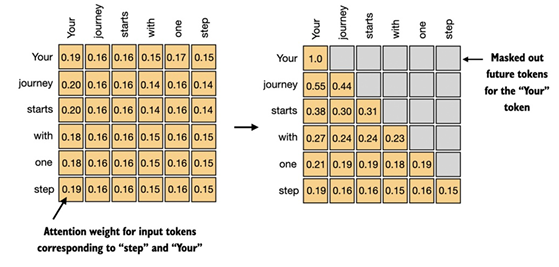

###  3.5.1 Applying a causal attention mask

Below is the procedure to implement this.

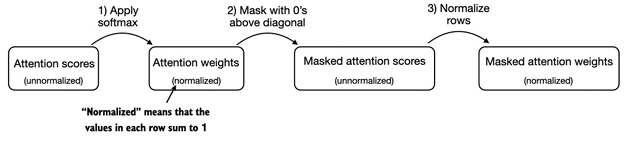

In the first step, we compute the attention weights
 using the softmax function

In [23]:
# Reuse the query and key weight matrices of the
# SelfAttention_v2 object from the previous section for convenience
queries = sa_v2.W_query(inputs)
keys = sa_v2.W_key(inputs) 
attn_scores = queries @ keys.T

attn_weights = torch.softmax(attn_scores / keys.shape[-1]**0.5, dim=-1)
print(attn_weights)

tensor([[0.1921, 0.1646, 0.1652, 0.1550, 0.1721, 0.1510],
        [0.2041, 0.1659, 0.1662, 0.1496, 0.1665, 0.1477],
        [0.2036, 0.1659, 0.1662, 0.1498, 0.1664, 0.1480],
        [0.1869, 0.1667, 0.1668, 0.1571, 0.1661, 0.1564],
        [0.1830, 0.1669, 0.1670, 0.1588, 0.1658, 0.1585],
        [0.1935, 0.1663, 0.1666, 0.1542, 0.1666, 0.1529]],
       grad_fn=<SoftmaxBackward0>)


The simplest way to mask out future attention weights is by creating a mask via PyTorch's tril function with elements below the main diagonal (including the diagonal itself) set to 1 and above the main diagonal set to 0.

In [24]:
context_length = attn_scores.shape[0]
mask_simple = torch.tril(torch.ones(context_length, context_length))
print(mask_simple)

tensor([[1., 0., 0., 0., 0., 0.],
        [1., 1., 0., 0., 0., 0.],
        [1., 1., 1., 0., 0., 0.],
        [1., 1., 1., 1., 0., 0.],
        [1., 1., 1., 1., 1., 0.],
        [1., 1., 1., 1., 1., 1.]])


Now, we can multiply this mask with the attention weights to zero out the
 values above the diagonal.

In [25]:
masked_simple = attn_weights*mask_simple
print(masked_simple)

tensor([[0.1921, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.2041, 0.1659, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.2036, 0.1659, 0.1662, 0.0000, 0.0000, 0.0000],
        [0.1869, 0.1667, 0.1668, 0.1571, 0.0000, 0.0000],
        [0.1830, 0.1669, 0.1670, 0.1588, 0.1658, 0.0000],
        [0.1935, 0.1663, 0.1666, 0.1542, 0.1666, 0.1529]],
       grad_fn=<MulBackward0>)


However, if the mask were applied after softmax, like above, it would disrupt the probability distribution created by softmax
Softmax ensures that all output values sum to 1
Masking after softmax would require re-normalizing the outputs to sum to 1 again, which complicates the process and might lead to unintended effects
To make sure that the rows sum to 1, we can normalize the attention weights as follows:

In [26]:
row_sums = masked_simple.sum(dim=-1, keepdim=True)
masked_simple_norm = masked_simple / row_sums
print(masked_simple_norm)

tensor([[1.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.5517, 0.4483, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.3800, 0.3097, 0.3103, 0.0000, 0.0000, 0.0000],
        [0.2758, 0.2460, 0.2462, 0.2319, 0.0000, 0.0000],
        [0.2175, 0.1983, 0.1984, 0.1888, 0.1971, 0.0000],
        [0.1935, 0.1663, 0.1666, 0.1542, 0.1666, 0.1529]],
       grad_fn=<DivBackward0>)


When we apply a mask and then renormalize the attention weights, it might
 initially appear that information from future tokens (which we intend to
 mask) could still influence the current token because their values are part of
 the softmax calculation. However, the key insight is that when we
 renormalize the attention weights after masking, what we're essentially doing
 is recalculating the softmax over a smaller subset (since masked positions
 don't contribute to the softmax value).
The mathematical elegance of softmax is that despite initially including all
 positions in the denominator, after masking and renormalizing, the effect of
 the masked positions is nullified — they don't contribute to the softmax score
 in any meaningful way.
 In simpler terms, after masking and renormalization, the distribution of
 attention weights is as if it was calculated only among the unmasked
 positions to begin with. This ensures there's no information leakage from
 future (or otherwise masked) tokens as we intended.

A more efficient way to obtain the masked attention weight matrix in causal attention
 is to mask the attention scores with negative infinity values before applying the softmax function.

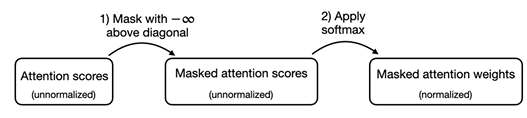

The softmax function converts its inputs into a probability distribution. When
 negative infinity values (-∞) are present in a row, the softmax function treats
 them as zero probability. (Mathematically, this is because e-∞ approaches 0.)

We can implement this more efficient masking "trick" by creating a mask
 with 1's above the diagonal and then replacing these 1's with negative infinity
 (-inf) values:

In [27]:
mask = torch.triu(torch.ones(context_length, context_length), diagonal=1)
masked = attn_scores.masked_fill(mask.bool(), -torch.inf)
print(masked)

tensor([[0.2899,   -inf,   -inf,   -inf,   -inf,   -inf],
        [0.4656, 0.1723,   -inf,   -inf,   -inf,   -inf],
        [0.4594, 0.1703, 0.1731,   -inf,   -inf,   -inf],
        [0.2642, 0.1024, 0.1036, 0.0186,   -inf,   -inf],
        [0.2183, 0.0874, 0.0882, 0.0177, 0.0786,   -inf],
        [0.3408, 0.1270, 0.1290, 0.0198, 0.1290, 0.0078]],
       grad_fn=<MaskedFillBackward0>)


Now, we need to apply the softmax function to these masked results.

In [28]:
attn_weights = torch.softmax(masked / keys.shape[-1]**0.5, dim=-1)
print(attn_weights)

tensor([[1.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.5517, 0.4483, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.3800, 0.3097, 0.3103, 0.0000, 0.0000, 0.0000],
        [0.2758, 0.2460, 0.2462, 0.2319, 0.0000, 0.0000],
        [0.2175, 0.1983, 0.1984, 0.1888, 0.1971, 0.0000],
        [0.1935, 0.1663, 0.1666, 0.1542, 0.1666, 0.1529]],
       grad_fn=<SoftmaxBackward0>)


### 3.5.2 Masking additional attention weights with dropout

Dropout in deep learning is a technique where randomly selected hidden
 layer units are ignored during training, effectively "dropping" them out. This
 method helps prevent overfitting by ensuring that a model does not become
 overly reliant on any specific set of hidden layer units.

 It's important to
 emphasize that dropout is only used during training and is disabled afterward.
 In the transformer architecture, including models like GPT, dropout in the
 attention mechanism is typically applied in two specific areas: after
 calculating the attention scores or after applying the attention weights to the
value vectors.

Here, we will apply the dropout mask after computing the attention weights.

Furthermore, in this specific example, we use a dropout rate of 50%, which means randomly masking out half of the attention weights.

If we apply a dropout rate of 0.5 (50%), the non-dropped values will be scaled accordingly by a factor of 1/0.5 = 2
The scaling is calculated by the formula 1 / (1 - dropout_rate)

This scaling is crucial to
 maintain the overall balance of the attention weights, ensuring that the
 average influence of the attention mechanism remains consistent during both
 the training and inference phases.

In [29]:
torch.manual_seed(123)
dropout = torch.nn.Dropout(0.5) # dropout rate of 50%
example = torch.ones(6, 6) # create a matrix of ones

print(dropout(example))

tensor([[2., 2., 2., 2., 2., 2.],
        [0., 2., 0., 0., 0., 0.],
        [0., 0., 2., 0., 2., 0.],
        [2., 2., 0., 0., 0., 2.],
        [2., 0., 0., 0., 0., 2.],
        [0., 2., 0., 0., 0., 0.]])


In [30]:
torch.manual_seed(123)
print(dropout(attn_weights))

tensor([[2.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.0000, 0.8966, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.6206, 0.0000, 0.0000, 0.0000],
        [0.5517, 0.4921, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.4350, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.0000, 0.3327, 0.0000, 0.0000, 0.0000, 0.0000]],
       grad_fn=<MulBackward0>)


### 3.5.3 Implementing a compact causal attention class


To implement the code to handle batches consisting of more than one input so that our CausalAttention class supports the batch outputs produced by the data loader.
For simplicity, to simulate such batch input, we duplicate the input text example:

In [31]:
batch = torch.stack((inputs, inputs), dim=0)
print(batch.shape) # 2 inputs with 6 tokens each, and each token has embedding dimension 3

torch.Size([2, 6, 3])


In [32]:
class CausalAttention(nn.Module):

    def __init__(self, d_in, d_out, context_length,
                 dropout, qkv_bias=False):
        super().__init__()
        self.d_out = d_out
        self.W_query = nn.Linear(d_in, d_out, bias=qkv_bias)
        self.W_key   = nn.Linear(d_in, d_out, bias=qkv_bias)
        self.W_value = nn.Linear(d_in, d_out, bias=qkv_bias)
        self.dropout = nn.Dropout(dropout) # New
        self.register_buffer('mask', torch.triu(torch.ones(context_length, context_length), diagonal=1)) # New

    def forward(self, x):
        b, num_tokens, d_in = x.shape # New batch dimension b
        # For inputs where `num_tokens` exceeds `context_length`, this will result in errors in the mask creation further below.
        keys = self.W_key(x)
        queries = self.W_query(x)
        values = self.W_value(x)

        attn_scores = queries @ keys.transpose(1, 2) # Changed transpose
        attn_scores.masked_fill_(  # New, _ ops are in-place
            self.mask.bool()[:num_tokens, :num_tokens], -torch.inf)  # `:num_tokens` to account for cases where the number of tokens in the batch is smaller than the supported context_size
        attn_weights = torch.softmax(
            attn_scores / keys.shape[-1]**0.5, dim=-1
        )
        attn_weights = self.dropout(attn_weights) # New

        context_vec = attn_weights @ values
        return context_vec

torch.manual_seed(123)

context_length = batch.shape[1]
ca = CausalAttention(d_in, d_out, context_length, 0.0)

context_vecs = ca(batch)

print(context_vecs)
print("context_vecs.shape:", context_vecs.shape)

tensor([[[-0.4519,  0.2216],
         [-0.5874,  0.0058],
         [-0.6300, -0.0632],
         [-0.5675, -0.0843],
         [-0.5526, -0.0981],
         [-0.5299, -0.1081]],

        [[-0.4519,  0.2216],
         [-0.5874,  0.0058],
         [-0.6300, -0.0632],
         [-0.5675, -0.0843],
         [-0.5526, -0.0981],
         [-0.5299, -0.1081]]], grad_fn=<UnsafeViewBackward0>)
context_vecs.shape: torch.Size([2, 6, 2])


The use of
 register_buffer in PyTorch is not strictly necessary for all use cases but
 offers several advantages here. For instance, when we use the
 CausalAttention class in our LLM, buffers are automatically moved to the
 appropriate device (CPU or GPU) along with our model. This means we don't need
 to manually ensure these tensors are on the same device as your model
 parameters, avoiding device mismatch errors.

## 3.6 Extending single-head attention to multi-head attention

The term "multi-head" refers to dividing the attention mechanism into
 multiple "heads," each operating independently. In this context, a single
 causal attention module can be considered single-head attention, where there
 is only one set of attention weights processing the input sequentially.

### 3.6.1 Stacking multiple single-head attention layers


We simply stack multiple single-head attention modules to obtain a multi-head attention module:

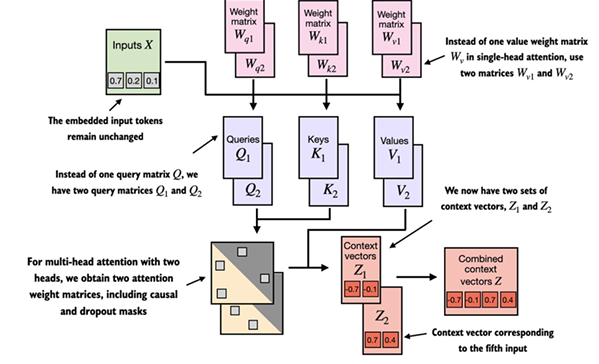

The main idea behind multi-head attention is to run the
 attention mechanism multiple times (in parallel) with different, learned linear
 projections -- the results of multiplying the input data (like the query, key,
 and value vectors in attention mechanisms) by a weight matrix.

In [33]:
class MultiHeadAttentionWrapper(nn.Module):

    def __init__(self, d_in, d_out, context_length, dropout, num_heads, qkv_bias=False):
        super().__init__()
        self.heads = nn.ModuleList(
            [CausalAttention(d_in, d_out, context_length, dropout, qkv_bias) 
             for _ in range(num_heads)]
        )

    def forward(self, x):
        return torch.cat([head(x) for head in self.heads], dim=-1)


torch.manual_seed(123)

context_length = batch.shape[1] # This is the number of tokens
d_in, d_out = 3, 2
mha = MultiHeadAttentionWrapper(
    d_in, d_out, context_length, 0.0, num_heads=2
)

context_vecs = mha(batch)

print(context_vecs)
print("context_vecs.shape:", context_vecs.shape)

tensor([[[-0.4519,  0.2216,  0.4772,  0.1063],
         [-0.5874,  0.0058,  0.5891,  0.3257],
         [-0.6300, -0.0632,  0.6202,  0.3860],
         [-0.5675, -0.0843,  0.5478,  0.3589],
         [-0.5526, -0.0981,  0.5321,  0.3428],
         [-0.5299, -0.1081,  0.5077,  0.3493]],

        [[-0.4519,  0.2216,  0.4772,  0.1063],
         [-0.5874,  0.0058,  0.5891,  0.3257],
         [-0.6300, -0.0632,  0.6202,  0.3860],
         [-0.5675, -0.0843,  0.5478,  0.3589],
         [-0.5526, -0.0981,  0.5321,  0.3428],
         [-0.5299, -0.1081,  0.5077,  0.3493]]], grad_fn=<CatBackward0>)
context_vecs.shape: torch.Size([2, 6, 4])


 The first dimension of the resulting context_vecs tensor is 2 since we have
 two input texts. The second dimension refers to the 6
 tokens in each input. The third dimension refers to the 4-dimensional
 embedding of each token.

Using the MultiHeadAttentionWrapper, we specified the number of attention heads
 (num_heads). If we set num_heads=2, as shown in this figure, we obtain a tensor with two sets of
 context vector matrices.

In each context vector matrix, the rows represent the context vectors
 corresponding to the tokens, and the columns correspond to the embedding dimension specified
 via d_out=4. We concatenate these context vector matrices along the column dimension. Since we
 have 2 attention heads and an embedding dimension of 2, the final embedding dimension is 2 × 2
 = 4.

###  3.6.2 Implementing multi-head attention with weight splits

We can write a stand-alone class called MultiHeadAttention to achieve the same.

 It splits the input into multiple heads by
 reshaping the projected query, key, and value tensors and then combines the
 results from these heads after computing attention.

In [34]:
class MultiHeadAttention(nn.Module):
    def __init__(self, d_in, d_out, context_length, dropout, num_heads, qkv_bias=False):
        super().__init__()
        assert (d_out % num_heads == 0), \
            "d_out must be divisible by num_heads"

        self.d_out = d_out
        self.num_heads = num_heads
        self.head_dim = d_out // num_heads # Reduce the projection dim to match desired output dim

        self.W_query = nn.Linear(d_in, d_out, bias=qkv_bias)
        self.W_key = nn.Linear(d_in, d_out, bias=qkv_bias)
        self.W_value = nn.Linear(d_in, d_out, bias=qkv_bias)
        self.out_proj = nn.Linear(d_out, d_out)  # Linear layer to combine head outputs
        self.dropout = nn.Dropout(dropout)
        self.register_buffer(
            "mask",
            torch.triu(torch.ones(context_length, context_length),
                       diagonal=1)
        )

    def forward(self, x):
        b, num_tokens, d_in = x.shape

        keys = self.W_key(x) # Shape: (b, num_tokens, d_out)
        queries = self.W_query(x)
        values = self.W_value(x)

        # We implicitly split the matrix by adding a `num_heads` dimension
        # Unroll last dim: (b, num_tokens, d_out) -> (b, num_tokens, num_heads, head_dim)
        keys = keys.view(b, num_tokens, self.num_heads, self.head_dim) 
        values = values.view(b, num_tokens, self.num_heads, self.head_dim)
        queries = queries.view(b, num_tokens, self.num_heads, self.head_dim)

        # Transpose: (b, num_tokens, num_heads, head_dim) -> (b, num_heads, num_tokens, head_dim)
        keys = keys.transpose(1, 2)
        queries = queries.transpose(1, 2)
        values = values.transpose(1, 2)

        # Compute scaled dot-product attention (aka self-attention) with a causal mask
        attn_scores = queries @ keys.transpose(2, 3)  # Dot product for each head

        # Original mask truncated to the number of tokens and converted to boolean
        mask_bool = self.mask.bool()[:num_tokens, :num_tokens]

        # Use the mask to fill attention scores
        attn_scores.masked_fill_(mask_bool, -torch.inf)
        
        attn_weights = torch.softmax(attn_scores / keys.shape[-1]**0.5, dim=-1)
        attn_weights = self.dropout(attn_weights)

        # Shape: (b, num_tokens, num_heads, head_dim)
        context_vec = (attn_weights @ values).transpose(1, 2) 
        
        # Combine heads, where self.d_out = self.num_heads * self.head_dim
        context_vec = context_vec.contiguous().view(b, num_tokens, self.d_out)
        context_vec = self.out_proj(context_vec) # optional projection

        return context_vec

torch.manual_seed(123)

batch_size, context_length, d_in = batch.shape
d_out = 2
mha = MultiHeadAttention(d_in, d_out, context_length, 0.0, num_heads=2)

context_vecs = mha(batch)

print(context_vecs)
print("context_vecs.shape:", context_vecs.shape)

tensor([[[0.3190, 0.4858],
         [0.2943, 0.3897],
         [0.2856, 0.3593],
         [0.2693, 0.3873],
         [0.2639, 0.3928],
         [0.2575, 0.4028]],

        [[0.3190, 0.4858],
         [0.2943, 0.3897],
         [0.2856, 0.3593],
         [0.2693, 0.3873],
         [0.2639, 0.3928],
         [0.2575, 0.4028]]], grad_fn=<ViewBackward0>)
context_vecs.shape: torch.Size([2, 6, 2])


 In the MultiheadAttention class, we initialize one larger weight matrix Wq ,
 only perform one matrix multiplication with the inputs to obtain a query matrix Q, and then split
 the query matrix into Q1 and Q2 as shown at the bottom of this figure. We do the same for the
 keys and values.